In [26]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat

  Activating project at `c:\Users\Daniel\Documents\Python-Projects\AiPEX-Projects\warmstarting_NLPs`


In [27]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

## Dynamics and Hermite-Simpson Integrator

In [28]:
function acrobot_dynamics(params, x, u)
    m1, m2 = params.m1, params.m2
    l1, l2 = params.l1, params.l2
    J1, J2 = params.J1, params.J2
    c = params.c

    g = 9.81
    # m1,m2 = [1.,1.]
    # l1,l2 = [1.,1.]
    # J1,J2 = [1.,1.]
    θ1,    θ2    = x[1], x[2]
    θ1dot, θ2dot = x[3], x[4]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    c12 = cos(θ1 + θ2)

    # mass matrix
    m11 = m1*l1^2 + J1 + m2*(l1^2 + l2^2 + 2*l1*l2*c2) + J2
    m12 = m2*(l2^2 + l1*l2*c2 + J2)
    m22 = l2^2*m2 + J2
    M = [m11 m12; m12 m22]

    # bias term
    tmp = l1*l2*m2*s2
    b1 = -(2 * θ1dot * θ2dot + θ2dot^2)*tmp
    b2 = tmp * θ1dot^2
    B = [b1, b2]

    # friction
    # c = 1.0
    C = [c*θ1dot, c*θ2dot]

    # gravity term
    g1 = ((m1 + m2)*l2*c1 + m2*l2*c12) * g
    g2 = m2*l2*c12*g
    G = [g1, g2]

    # equations of motion
    τ = [0, u[1]]
    θddot = M\(τ - B - G - C)
    return [θ1dot, θ2dot, θddot[1], θddot[2]]
end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    x_m = 0.5*(x1 + x2) + 0.125*dt*(acrobot_dynamics(params, x1, u) - acrobot_dynamics(params, x2, u))
    res = x1 + (dt/6.0)*(acrobot_dynamics(params, x1, u) + 4*acrobot_dynamics(params, x_m, u) + acrobot_dynamics(params, x2, u)) - x2
    return res
end



hermite_simpson (generic function with 1 method)

## NLP Costs and Constraints

In [33]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function acrobot_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input arobot LQR cost 
    J = 0 

    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi-xg)'*Q*(xi-xg) + 0.5*ui'*R*ui
    end
    
    # dont forget terminal cost 
    xN = Z[idx.x[N]]
    J += 0.5*(xN-xg)'*Qf*(xN-xg)
    return J 
end

function acrobot_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function acrobot_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    return [Z[idx.x[1]] - xic; Z[idx.x[end]] - xg; acrobot_dynamics_constraints(params, Z)] 
end

function solve_acrobot_swingup(params::NamedTuple; verbose=true)
    dt = params.dt
    N = params.N

    idx = params.idx

    # TODO: primal bounds 
    x_l = fill(-Inf, idx.nz)
    x_u = fill(Inf, idx.nz)
    
    for i = 1:(N-1)
        x_l[idx.u[i]] .= -10
        x_u[idx.u[i]] .= 10
    end

    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    # diff_type = :auto 
    diff_type = :finite
    
    # @show arobot_equality_constraint(params, z0)
    # @show arobot_dynamics_constraints(params, z0)
    # @show inequality_constraint(params, z0)
    # @show arobot_cost(params, z0)
        
    Z, obj, term_status = fmincon(acrobot_cost,acrobot_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 1_000, verbose = verbose)

    # pull the X and U solutions out of Z 
    @show Z
    @show size(Z)
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, obj, t_vec, params 
end

# @testset "arobot swingup" begin 
    
#     X, U, t_vec = solve_cartpole_swingup(verbose=true)
#     @show size(X)
#     @show size(U)
    
#     # --------------testing------------------
#     @test isapprox(X[1],zeros(4), atol = 1e-4)
#     @test isapprox(X[end], [0,pi,0,0], atol = 1e-4)
#     Xm = hcat(X...)
#     Um = hcat(U...)
    
#     # --------------plotting-----------------
#     display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
#     display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))
    
#     # meshcat animation
#     display(animate_cartpole(X, 0.05))
    
# end

solve_acrobot_swingup (generic function with 1 method)

## Sample the NLP solutions for different points in the parameter space

In [30]:
# Problem size
nx = 4 
nu = 1 
dt = 0.05
tf = 5.0
t_vec = 0:dt:tf 
N = length(t_vec)

# LQR cost 
Q = diagm(ones(nx))
R = 0.1*diagm(ones(nu))
Qf = 10*diagm(ones(nx))

# indexing 
idx = create_idx(nx,nu,N)

# initial and goal states 
xic = [-pi/2, 0, 0, 0]
xg = [pi/2, 0, 0, 0]

# load all useful things into params 
m1, m2 = 1, 1
l1, l2 = 1, 1
J1, J2 = 1, 1
c = 0.1

params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, m1=m1, m2=m2, l1=l1, l2=l2, J1=J1, J2=J2, c=c)
X, U, obj, t_vec, params = solve_acrobot_swingup(params)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :finite (FiniteDiff.jl)---
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   205632
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints......

([[-1.5707963266315996, -8.276745282588501e-13, 2.9022156238857774e-13, 2.433919023024354e-13], [-1.4730828831509157, 0.01758849642430011, -0.3127915481536061, 0.7045702919501123], [-1.2408362394021217, 0.07065025051220031, -0.6668470466385377, 1.4205372918660382], [-1.2835080731331265, 0.1592853254801698, -1.0351784152319565, 2.1147220945234015], [-1.343740976340435, 0.28083467146798025, -1.3666666001661216, 2.73148071135], [-1.4192977791850574, 0.43057308442988873, -1.645703603862086, 3.2369626863418697], [-1.507237335171196, 0.602236131187749, -1.8606932883978853, 3.605621257106621], [-1.6042479761294897, 0.7887406323471041, -2.008953637357521, 3.8315554311725846], [-1.707130172810702, 0.9832647481229345, -2.0972897378911153, 3.93042636558204], [-1.81318102957578, 1.1801426321206607, -2.137867695883669, 3.9309185063871075]  …  [1.5612788875103258, -1.1963029080899272, -1.4338891415772423, 5.418758900263788], [1.489914357460631, -0.9367870103367291, -1.4057797282772968, 4.94513895637

size(t_vec) = (101,)
typeof(X) = Vector{Vector{Float64}}
size(Xm') = (101, 4)
Xm = [-1.5707963266315996 -1.4730828831509157 -1.2408362394021217 -1.2835080731331265 -1.343740976340435 -1.4192977791850574 -1.507237335171196 -1.6042479761294897 -1.707130172810702 -1.81318102957578 -1.920329011260722 -2.027052982959714 -2.132204716600112 -2.2348304483321555 -2.3340365486580885 -2.4289113929545154 -2.5185012480890663 -2.6018319682547943 -2.6779637843329547 -2.7460621550226527 -2.8054654004869874 -2.855732053636784 -2.896658143436727 -2.928264743522851 -2.9507650544387958 -2.9645247211807417 -2.97002835234919 -2.967861139702219 -2.952824281403228 -2.9187798770540536 -2.86502016390734 -2.7909840807364237 -2.696334061824408 -2.5810124225609443 -2.445305964392533 -2.2899454396232497 -2.116253088094286 -1.9263225093494878 -1.7231752240969211 -1.5108041726250545 -1.2940086713148788 -1.0779635415555242 -0.8675515319305243 -0.6666108663361316 -0.4773473379440949 -0.30012354569424055 -0.133641477194

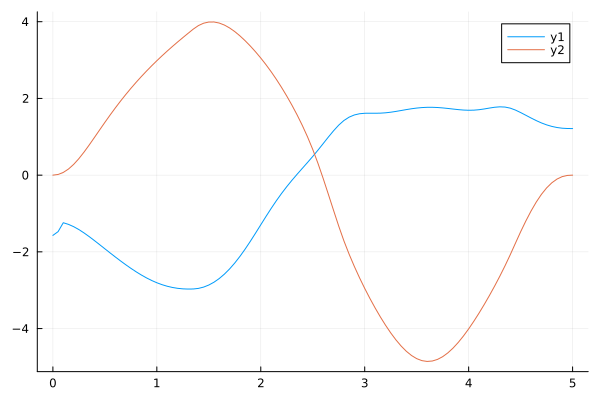

In [31]:
@show size(t_vec)
@show typeof(X)
Xm = hcat(X...)
@show size(Xm')

@show Xm
@show Xm'
plot(t_vec, Xm'[:, 1:2])

In [34]:
# function build_acrobot!()
vis = Visualizer()
vis["robot"]

┌ Info: Listening on: 127.0.0.1:8719, thread id: 1
└ @ HTTP.Servers C:\Users\Daniel\.julia\packages\HTTP\sJD5V\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8719
└ @ MeshCat C:\Users\Daniel\.julia\packages\MeshCat\0RCA3\src\visualizer.jl:64


MeshCat Visualizer with path /meshcat/robot at http://127.0.0.1:8719